In [10]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [11]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
#input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
#input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
#input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
#input_names.append('TKE+IDEMIX, jayne')
#input_names.append('TKE+IDEMIX, nycander')
#input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl         = None 
do_allcycl     = True 
vname          = 'vec+tu+tv' # vec+u+v, vec+unod+vnod, vec+tu+tv
vnamet         = 'temp'
year           = [1979,2014]
mon            = None
day            = None
record         = None 
box            = None
depth          = None
do_edgevec_r2g = False   # set to true if u,v data are already in geo-coordinates
do_datavec_r2g = False   # --> edgevec rotation and datavec rotation must be in same context
do_bolus       = False  # add bolus velocity to vec+u+v

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Boxregion via shape file for index compuation______________________________
box_region = list()
box_region.append('global')
# box_region.append('moc_basins/Atlantic_MOC.shp')
# box_region.append('moc_basins/IndoPacific_MOC.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('ocean_basins/Pacific_Basin.shp')

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 1      # number of pannel columns in figure
nrow              = 1
plt_opt           = dict({'marker':'o'})
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
save_dpi          = 300
save_fmt          = ['png']

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None

In [12]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread,
                                       do_dashbrdlnk=True)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Dask client already running: <Client: 'tcp://127.0.0.1:33873' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43147/status,
Dashboard: http://127.0.0.1:43147/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33873,Workers: 32
Dashboard: http://127.0.0.1:43147/status,Total threads: 64
Started: 34 minutes ago,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:44217,Total threads: 2
Dashboard: http://127.0.0.1:39165/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:37053,


In [13]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
    
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0

#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : -1, #12, #'auto', #'auto'    , 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : -1, #mesh.nlev-1, 
               'nz'   : -1, #mesh.nlev, 
               'edg_n': (mesh.n2dn*3)}) # --> there are ~3times as many edges than nodes

if client is not None:
    # set size limit of time chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.05
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 # dive by 4 because we use 4byte single precision
    if   chunks['time'] == -1    : chunk_size = chunk_size/12    
    elif chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']    
    # if   chunks['nod2'] == -1    : chunk_size = chunk_size/mesh.n2dn
    # elif chunks['elem'] == -1    : chunk_size = chunk_size/mesh.n2de
    # elif chunks['nod2'] != 'auto': chunk_size = chunk_size/chunks['nod2']    
    # elif chunks['elem'] != 'auto': chunk_size = chunk_size/chunks['elem']
    if   chunks['nz']   == -1    : chunk_size = chunk_size/mesh.nlev
    elif chunks['nz1']  == -1    : chunk_size = chunk_size/mesh.nlev
    elif chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    # chunks['nz1'] = np.int32(np.ceil(chunk_size))
    # chunks['nz' ] = np.int32(np.ceil(chunk_size))
    # chunks['time'] = np.int32(np.ceil(chunk_size))
    chunks['elem'] = np.minimum(mesh.n2de, np.int32(np.ceil(chunk_size)))
    if chunks['elem']>mesh.n2de*0.5: chunks['elem']=mesh.n2de
    chunks['nod2'] = np.minimum(mesh.n2dn, np.int32(np.ceil(chunk_size)))
    # print(' --> set nz1 chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['nz1']))
    # print(' --> set time chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['time']))
    print(' --> set nod2/elem chunk size to {:2.2f}% of worker mem.: {:d}, {:d}'.format(100*mem_thresh, chunks['nod2'],  chunks['elem']))
print(chunks)

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
global
 --> worker memory      : 6866.46Mb
 --> limit chunksize to : 343.32Mb
 --> set nod2/elem chunk size to 5.00% of worker mem.: 126858, 244659
{'time': -1, 'elem': 244659, 'nod2': np.int32(126

In [14]:
ts = clock.time()
datapath = input_paths[0]
#___________________________________________________________________________
# load information about edges 
fname = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy', 'edge_nodes', 'edge_face_links' ]
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
            
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
        if x[var].dtype=='int64'  : x[var] = x[var].astype('int32')
        # there were some changings in the fesom.mesh.diag.nc variable naming from fesom 2.5-->2.6
        # for some reason he load now edge_nodes and edge_face_links as float32, while they cant
        # be used as indices by default and need to be converted by hand into int32
        if   var in ['edge_nodes'     ]: x = x.rename({'edge_nodes'     :'edges'})#.astype('int32')                
        elif var in ['edge_face_links']: x = x.rename({'edge_face_links':'edge_tri'})#.astype('int32')                
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
# decode_cf=False is need so that the original fillvalue of -999 is used instead of NaN
# or np.iinfo(np.int32).max()
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=True, 
                             engine='netcdf4', chunks=dict({'edg_n':-1,'n2':1}), 
                             preprocess=partial_func,  decode_cf=False)
mdiag = mdiag.drop_vars(list(mdiag.coords)).unify_chunks()
mdiag = mdiag.assign_coords({'edges'          :mdiag['edges'], 
                             'edge_tri'       :mdiag['edge_tri'], 
                             'edge_cross_dxdy':mdiag['edge_cross_dxdy']})

# node indices of edge points [2 x n2ded]--> indices in python start with 0
mdiag['edges']    = mdiag['edges']-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
# --> indices in python start with 0
mdiag['edge_tri'] = mdiag['edge_tri']-1

# Suppress the specific warning about sending large graphs
warnings.filterwarnings("ignore", category=UserWarning, message="Sending large graph of size")

#___________________________________________________________________________
# add edge coordinates and edge mid point coordinates
set_mdiag_chunk = dict({'edg_n': mdiag.chunksizes['edg_n'], 'n2':mdiag.chunksizes['n2']})
mdiag = mdiag.assign_coords(edge_x = xr.DataArray(mesh.n_x[mdiag.edges], dims=['n2','edg_n']).astype('float32').chunk(set_mdiag_chunk))
mdiag = mdiag.assign_coords(edge_y = xr.DataArray(mesh.n_y[mdiag.edges], dims=['n2','edg_n']).astype('float32').chunk(set_mdiag_chunk))
# mdiag = mdiag.drop_vars('edges')

mdiag = mdiag.assign_coords(edge_mx = mdiag.edge_x.sum(dim='n2')/2.0)
mdiag = mdiag.assign_coords(edge_my = mdiag.edge_y.sum(dim='n2')/2.0)

#___________________________________________________________________________
# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    mdiag.edge_cross_dxdy.data[0,:], mdiag.edge_cross_dxdy.data[1,:] = tpv.vec_r2g_dask(mesh.abg, mdiag.edge_mx.data, mdiag.edge_my.data, 
                                                                         mdiag.edge_cross_dxdy.data[0,:], mdiag.edge_cross_dxdy.data[1,:], 
                                                                         gridis='geo', do_info=False )
    mdiag.edge_cross_dxdy.data[2,:], mdiag.edge_cross_dxdy.data[3,:] = tpv.vec_r2g_dask(mesh.abg, mdiag.edge_mx, mdiag.edge_my, 
                                                                         mdiag.edge_cross_dxdy.data[2,:], mdiag.edge_cross_dxdy.data[3,:], 
                                                                         gridis='geo', do_info=False )

#___________________________________________________________________________
# set_mdiag_chunk = dict({'edg_n': mdiag.chunksizes['edg_n'], 'n2':mdiag.chunksizes['n2']})
# set_mdiag_chunk = dict({'n2':1})
# dx & dy of left triangle --> cross-edge vector 
mdiag = mdiag.assign_coords(edge_dxdy_l=xr.DataArray( np.array([ mdiag.edge_cross_dxdy[0,:], 
                                                                 mdiag.edge_cross_dxdy[1,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))
# dx & dy of right triangle --> cross-edge vector 
mdiag = mdiag.assign_coords(edge_dxdy_r=xr.DataArray( np.array([ mdiag.edge_cross_dxdy[2,:], 
                                                                 mdiag.edge_cross_dxdy[3,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))

# if boundarie edge --> right triangle doesnot exist --> therefor dx,dy is zero there
idx = mdiag.edge_tri[1,:]<0
mdiag.edge_dxdy_r[:, idx.load()]=0. 
# mdiag.edge_dxdy_r[:, mdiag.edge_tri[1,:]<0]=0. 

#___________________________________________________________________________
# restructure edge_dxdy_l & edge_dxdy_r into edge_dx_lr0 & edge_dx_lr1
mdiag = mdiag.assign_coords(edge_dx_lr=xr.DataArray( np.array([ mdiag.edge_dxdy_l[0,:], 
                                                         mdiag.edge_dxdy_r[0,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))
# dx & dy of right triangle --> norm vector 
mdiag = mdiag.assign_coords(edge_dy_lr=xr.DataArray( np.array([ mdiag.edge_dxdy_l[1,:], 
                                                         mdiag.edge_dxdy_r[1,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))

#___________________________________________________________________________
# now drop edge_cross_dxdy variable dont need anymore
mdiag = mdiag.drop_vars(['edge_cross_dxdy', 'edge_dxdy_l', 'edge_dxdy_r', 'edge_mx', 'edge_my', ]) #

if do_parallel: mdiag = mdiag.persist()
else          : mdiag = mdiag.load()
display(mdiag)
mdiag.close()

#___________________________________________________________________________
warnings.resetwarnings()
print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))
print(' --> mdiag uses {:3.2f} Gb:'.format(mdiag.nbytes/(1024**3)))

<xarray.Dataset> Size: 18MB
Dimensions:     (n2: 2, edg_n: 371644)
Coordinates:
    edges       (n2, edg_n) int32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_tri    (n2, edg_n) int32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_x      (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_y      (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_dx_lr  (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_dy_lr  (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
Dimensions without coordinates: n2, edg_n
Data variables:
    *empty*

 --> elasped time: 0.011746954917907716 min.
 --> mdiag uses 0.02 Gb:


In [15]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
# load t*u and t*v together
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()

    #__________________________________________________________________________________________________
    # input parameter shortcut
    input_dict = dict({'year':year, 'mon':mon, 'descript':descript, 'do_rot':do_datavec_r2g,
                       'do_info':False, 
                       'do_tarithm':'mean', # do time mean 
                       'do_zarithm': None , # do area weighted vertical integration
                       'do_ie2n':False, 'do_nan':False, 
                       'chunks':chunks, 'do_load':False, 'do_persist':True, 'do_parallel':do_parallel, 
                       'client':client})
    
    #__________________________________________________________________________________________________
    if vname in ['vec+tu+tv']:
        # load temp*velocities --> do here already deth  weighted vertical integration to further reduce 
        # data sizes 
        data, datat = tpv.load_data_fesom2(mesh, datapath, vname=vname, **{**input_dict, 'do_zarithm':'wint'}), None
        if data is None: raise ValueError(f'data == None, {vname} data could not be read, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________
    elif vname in ['vec+u+v', 'vec+unod+vnod']:
        # load velocities
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict)
        if data is None: raise ValueError(f'data == None, {vname} data could not be read, your path:{datapath} might be wrong!!!')
        # display(data)
        data.close()

        # add bolus velocities
        if do_bolus and vname == 'vec+u+v':
            data_bv = tpv.load_data_fesom2(mesh, datapath, vname='vec+bolus_u+bolus_v', year=year, **input_dict)
            data['u'], data['v'] = data['u']+data_bv['bolus_u'], data['v']+data_bv['bolus_v']
            del(data_bv)
            
        # load temperature
        datat = tpv.load_data_fesom2(mesh, datapath, vname=vnamet, **input_dict)
        if datat is None: raise ValueError(f'datat == None, {vnamet} data could not be read, your path:{datapath} might be wrong!!!')
        # display(datat)
        datat.close()
        
    #__________________________________________________________________________________________________
    else:
        raise ValueError(f' --> vname={vname} is not supported for this transport computation ')

    from dask.distributed import wait
    if data is None: wait([data       ])  # Wait until finished loading of data and datat
    else           : wait([data, datat])  # Wait until finished loading of data and datat
    
    # transform all data from elem/vertice context into edge context
    data_edge = mdiag.copy(deep=True)
    if 'nz1'  in data.dims  : data_edge = data_edge.assign_coords(dz = xr.DataArray(np.abs(np.diff(mesh.zlev)).astype(np.float32), dims='nz1'))
    if 'time' in data.coords: data_edge = data_edge.assign_coords(time = data['time'])
    vnameU,vnameV = list(data.data_vars)
    
    # change velocity data from elem --> edge context
    if   'elem' in data.dims:
        do_onelem = True
        drop_list = list(data.coords)
        data_edge = data_edge.assign({ vnameU:xr.concat([data[ vnameU].isel({'elem': mdiag['edge_tri'].isel(n2=0)}).drop_vars(drop_list), 
                                                         data[ vnameU].isel({'elem': mdiag['edge_tri'].isel(n2=1)}).drop_vars(drop_list)], dim="n2"), 
                                       vnameV:xr.concat([data[ vnameV].isel({'elem': mdiag['edge_tri'].isel(n2=0)}).drop_vars(drop_list), 
                                                         data[ vnameV].isel({'elem': mdiag['edge_tri'].isel(n2=1)}).drop_vars(drop_list)], dim="n2") })
    
    # change velocity data from vertice --> edge context
    elif 'nod2' in data.dims:   
        do_onelem = False
        drop_list = list(data.coords)
        if datat is not None: 
            data = data*datat[vnamet] # to u*temp, v*temp
            del(datat)
            gc.collect()
            datat = None
        data_edge = data_edge.assign({ vnameU:xr.concat([data[ vnameU].isel({'nod2': mdiag['edges'   ].isel(n2=0)}).drop_vars(drop_list), 
                                                         data[ vnameU].isel({'nod2': mdiag['edges'   ].isel(n2=1)}).drop_vars(drop_list)], dim="n2"),
                                       vnameV:xr.concat([data[ vnameV].isel({'nod2': mdiag['edges'   ].isel(n2=0)}).drop_vars(drop_list), 
                                                         data[ vnameV].isel({'nod2': mdiag['edges'   ].isel(n2=1)}).drop_vars(drop_list)], dim="n2") })
        
    # velocity is already in edge context (not supported yet from the model)
    elif 'edg_n' in data.dims:   
        do_onelem = False
        drop_list = list(data.coords)
        data_edge = data_edge.assign({ vnameU:data[ vnameU], vnameV:data[ vnameV]})
    
    # change temperature data from vertice --> edge context    
    if datat is not None:
        drop_list = list(datat.coords)
        data_edge = data_edge.assign({ vnamet:xr.concat([datat[vnamet].isel({'nod2': mdiag['edges'   ].isel(n2=0)}).drop_vars(drop_list), 
                                                         datat[vnamet].isel({'nod2': mdiag['edges'   ].isel(n2=1)}).drop_vars(drop_list)], dim="n2") })
    
    data_edge = data_edge.unify_chunks()    
    if do_parallel: data_edge = data_edge.persist()
    else          : data_edge = data_edge.load()
    
    display(data_edge)
    del(data, datat)
    gc.collect()
    print(' --> elapsed time to load, prepare u,v, temp data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data_edge uses {:3.2f} Gb:'.format(data_edge.nbytes/(1024**3)))
    
    #__________________________________________________________________________________________________
    # compute meridional heat flux from t*v by binning
    # calc_mhflx_box_fast_lessmem(mesh, data, datat, mdiag, box, dlat=1.0, do_parallel=do_parallel, n_workers=parallel_nprc_bin, do_info=False))
    ts = clock.time()
    mhflx = tpv.calc_mhflx_box_dask(mesh, data_edge, box, do_parallel, parallel_nprc, do_lonlat='edge_x', dlonlat=1.0, do_onelem=do_onelem, client=client, do_checkbasin=False)
    del(data_edge)
    gc.collect()
    print(' --> elapsed time to comp. merid. hflux: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    
    # #__________________________________________________________________________________________________
    data_list.append(mhflx)
    if client is not None: client.run(gc.collect)
        
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  )) 

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE


<xarray.Dataset> Size: 24MB
Dimensions:     (n2: 2, edg_n: 371644)
Coordinates:
    edges       (n2, edg_n) int32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_tri    (n2, edg_n) int32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_x      (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_y      (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_dx_lr  (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    edge_dy_lr  (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
Dimensions without coordinates: n2, edg_n
Data variables:
    tu          (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>
    tv          (n2, edg_n) float32 3MB dask.array<chunksize=(1, 371644), meta=np.ndarray>

 --> elapsed time to load, prepare u,v, temp data: 1.88 min.
 --> data_edge uses 0.02 Gb:
 --> nchunk= 1 --> rechunk: 1 -> 64
 --> elapsed time to comp. merid. hflux: 0.03 min.
 --> total elasped time to process data: 1.91 min.


1 1


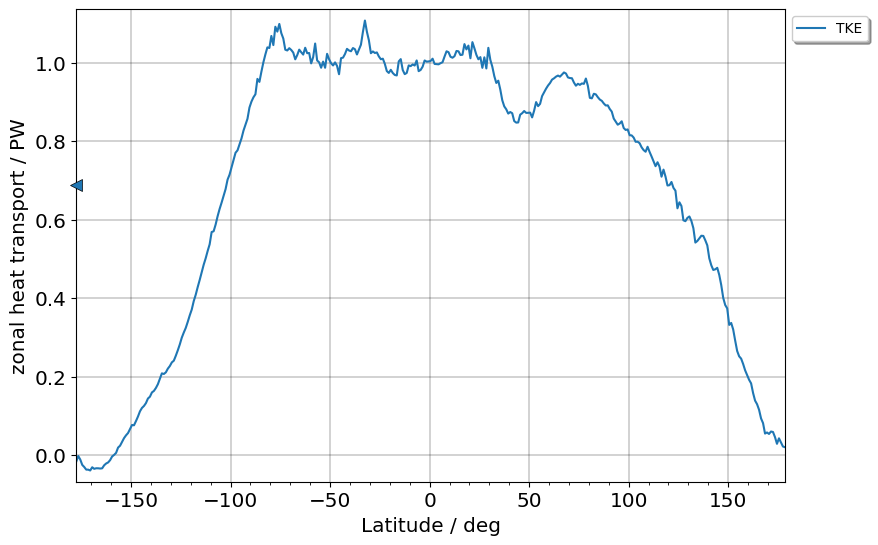

In [16]:
nbox = len(box)
if   ncol != None: 
    ncol0  = np.min([ncol,nbox])    
    nrow0  = np.ceil(nbox/ncol0).astype('int')
    if nrow != None: nrow0=nrow 
elif nrow != None: 
    nrow0  = np.min([nrow,nbox])    
    ncol0  = np.ceil(nbox/nrow0).astype('int') 
svname = list(data_list[0][0].data_vars)[0]
slabel = data_list[0][0][svname].attrs['str_lsave']
sbox   = data_list[0][0][svname].attrs['boxname'].replace(' ','_').lower()
print(nrow0, ncol0)
#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, 'hline' ,slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#__________________________________________________________________________________________________
hfig, hax = tpv.plot_hline(data_list           , 
                    box        = box           , 
                    box_idx    = None          ,
                    boxl_opt   = dict()        , # option for box label string 
                    nrow       = nrow0         , # number of row in figures panel
                    ncol       = ncol0         ,
                    ax_opt=dict({'fig_sizefac':3,}),
                    do_allcycl = do_allcycl    ,   
                    n_cycl     = n_cycl        ,
                    do_enum    = do_enum       ,
                    do_shdw    = do_shdw       ,
                    do_mean    = do_mean       ,
                    do_save    = sfpath, save_dpi=save_dpi  )

In [17]:
if do_papermill and do_parallel and client is not None: client.shutdown()